# Assignment 7: Sound localization
### Dhruv Prasad, EE23B130

In [10]:
# Imports
import numpy as np
from typing import Tuple, List
import matplotlib.pyplot as plt
from numpy.typing import ArrayLike

# To show interactive plots in jupyter notebooks
%matplotlib ipympl

## Part 1: Generating mic array samples
Given the main system parameters, generate samples which will be detected by the mics, and plot graphs to visualise them.
These parameters are:
1) Number of mics and spacing between them (Mics are evenly spaced about the origin along the y-axis)
2) Location of source
3) Location of obstacle
4) Sampling rate
5) Nature of waveform produced by source

In [11]:
# Some helper functions
def get_mic_positions(pitch: float, Nmics: int)->ArrayLike:
    ''' Function to get positions of mics given number of mics and distance between them
        Mics are evenly spaced about the origin along the y-axis'''
    mics = []
    offset = (Nmics/2-0.5)*pitch
    for i in range(0, Nmics):
        mics.append((0, (i*pitch - offset)))
    return np.array(mics)

def calculate_distance(pos1: Tuple, pos2: Tuple) -> float:
    ''' Function to find distance between two points '''
    return ((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2) ** (0.5)

def total_distance(src: Tuple, pt: Tuple, mic: Tuple):
    ''' Distance from src to a mic after reflecting through pt '''
    d1 = calculate_distance(src, pt) # distance from src to pt
    d2 = calculate_distance(pt, mic) # distance from pt to mic
    return d1 + d2

In [12]:
# Defining all the system parameters
# Can change them to test with different values

# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 200
# Source: x,y coordinates: x: 0+, y: [-Y, +Y] where Y determined by pitch and Nmics
src = (0, 0)
# Spacing between microphones
pitch = 0.1
# proxy for sampling rate
dist_per_samp = 0.1
# Speed of sound in the medium
c = 2.0
# Time dilation factor for sinc pulse: how narrow the pulse is
SincP = 5.0
# Locations of microphones
mics = get_mic_positions(pitch=pitch, Nmics=Nmics)

# Location of point obstacle
obstacle = (3, -1)

# Source sound wave - time axis and wave
# Sinc wave with narrowness determined by parameter
def wsrc(t):
    return np.sinc(SincP*t)

In [13]:
def generate_sample(Nsamp: int, Nmics: int, src: Tuple, obstacle: Tuple, mics: List[Tuple], dist_per_samp: float)->Tuple[ArrayLike, ArrayLike]:
    ''' Function to generate the samples as a 2D numpy array '''
    time_stamps = []
    for j in range(Nsamp):
            time_stamps.append(j*dist_per_samp/c)

    outputs_list = []
    for i in range(Nmics):
        delay_dist = total_distance(src=src, pt=obstacle, mic=mics[i])
        samples = []
        for j in range(Nsamp):
            samples.append(wsrc(time_stamps[j]-(delay_dist/c)))
        outputs_list.append(samples)
    outputs_list = np.array(outputs_list)
    return (outputs_list, time_stamps)

outputs_list, time_stamps = generate_sample(Nsamp=Nsamp, Nmics=Nmics, src=src, obstacle=obstacle, mics=mics, dist_per_samp=dist_per_samp)

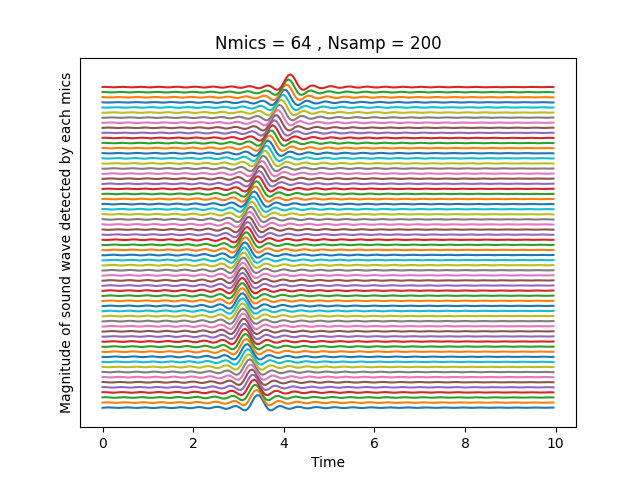

In [14]:
# Plot the outputs
# Define as a function as it will be used again later

def plot_samples(outputs_list: ArrayLike, time_stamps: ArrayLike):
    plt.figure()
    frame = plt.gca()
    for i in range(len(outputs_list)):
        plt.plot(time_stamps, [y+4*mics[i][1] for y in outputs_list[i]])
        # Adding 4 times the y coordinate of the mic to space out the graphs of each mic (just for visualisation)
        plt.ylabel("Magnitude of sound wave detected by each mics")
        frame.axes.get_yaxis().set_ticks([])
        plt.xlabel("Time")
        plt.title("Nmics = " + str(len(outputs_list)) + " , Nsamp = " + str(len(outputs_list[0])))
    plt.show()

plot_samples(outputs_list=outputs_list, time_stamps=time_stamps)

## Part 2: Visualising obstacles
Given samples of an array of mics, generate a heatmap that helps know the positions of the obstacles using delay and sum algorithm.

In [ ]:
# Uncomment these to use samples of 2 and 3 obstacles given in the assignment on eex moodle

# outputs_list = np.loadtxt("rx2.txt")
# outputs_list = np.loadtxt("rx3.txt")

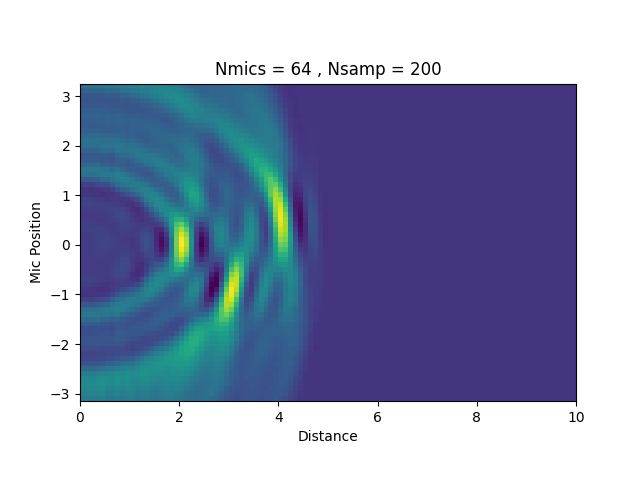

In [22]:
def plot_heatmap(outputs_list: ArrayLike, Nsamp: int, Nmics: int, pitch: float, dist_per_samp: float):
    ''' Function to plot a heatmap using delay and sum approach'''
    grid = [[0] * int(Nsamp/2) for _ in range(Nmics)] # Create an empty grid
    # Here, one unit on the y-axis depicts one pitch distance. 
    # Suppose the mics are placed in [-Y, Y], I assume the obstacle is also within this range
    # One unit on the x-axis depicts one distance_per_samp.
    # Assuming our samples always contain the peak of the sinc pulse, max x-coord is taken as Nmics/2.
    # This is still not the optimal limit of our x range, detailed explanation is provided in the report

    # Fill the heatmap grid by summing contributions from each microphone
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            # Convert each i,j in the grid to actual coordinates
            point = (j*dist_per_samp, i*pitch-(Nmics/2-0.5)*pitch)
            for k in range(Nmics):
                # Calculate the distance sound would have to travel to reach a mic considering obstacle at i,j
                delay_dist = total_distance(src=src, pt=point, mic=mics[k])

                # Convert the delay distance into samples and clamp it to be within correct range
                delay_samples = max(int(delay_dist/dist_per_samp),0)
                delay_samples = min(delay_samples, int(Nsamp/2)-1)
                # Add that sample of the mic which would have been a peak if the obstacle was actually at i,j
                grid[i][j]+=outputs_list[k][delay_samples]
    # Set ranges and labels and plot the heatmap
    plt.figure()
    plt.imshow(grid, extent=[0, Nsamp * dist_per_samp / 2, 0 - (Nmics/2-0.5)*pitch, Nmics*pitch - (Nmics/2-0.5)*pitch], origin='lower')
    plt.xlabel('Distance')
    plt.ylabel('Mic Position')
    plt.title("Nmics = " + str(Nmics) + " , Nsamp = " + str(Nsamp))
    plt.show()

plot_heatmap(outputs_list=outputs_list, Nsamp=Nsamp, Nmics=Nmics, pitch=pitch, dist_per_samp=dist_per_samp)

## Part 3: Questions given in assignment pdf
Below is the code I used to answer the various questions given in assignment pdf
### 1) Sincs

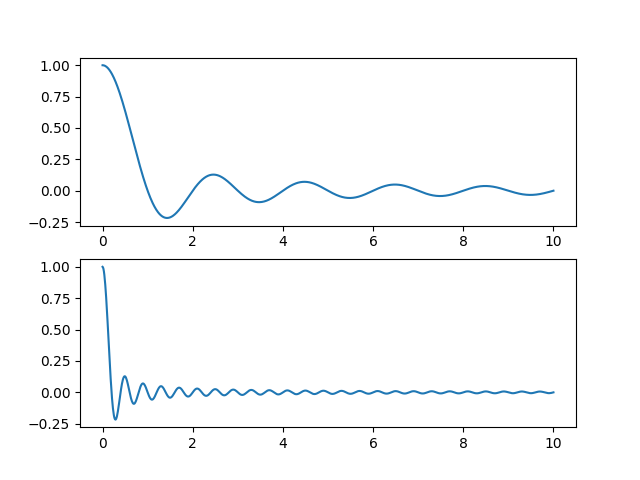

In [17]:
x=np.linspace(0, 10, 1000)
y1=np.sinc(x)
y2=np.sinc(5*x)
fig, ax = plt.subplots(2,1)
ax[0].plot(x,y1)
ax[1].plot(x,y2)
plt.show()
# Hence to make these sinc pulses narrower or broader, we need to change the factor multiplied with input 'SincP'

### 2) Upper Limit for X-axis

Assuming our samples always contain the peak of the signals, the maximum delay in distance with which a microphone could detect a pulse is given by:

**Max Delay** = `Nsamp * dist_per_samp`

If this entire delay was along the x-axis, the maximum x-coordinate needed would be:

`(Nsamp * dist_per_samp) / 2`

Since we are plotting with each unit on the x-axis corresponding to one `dist_per_samp`, we can go up to:

`Nsamp / 2`

### 3) Obstacle Coordinates

In the assignment's reference image, the coordinates corresponding to the maximum amplitude are approximately (30, 22). This observation is based on the following:

- The x-axis represents samples up to `Nsamp / 2`.
- The y-axis represents microphone indices, with values ranging from 0 to 64 (from top to bottom).

To convert the x-coordinate to actual distance:

`30 * dist_per_samp = 3`

Similarly, for the y-coordinate:

`22 * (pitch) - ((Nmics / 2 - 0.5) * pitch) = -1 approximately`

Therefore, (30, 22) corresponds to an obstacle located at (3, -1).

### 4) Farthest Obstacles Detectable in X and Y

The maximum delay distance for any microphone is:

`Nsamp * dist_per_samp`

#### Maximum Distance in X

By symmetry, the farthest x-coordinate will be achieved when obstacle is at some (x, 0). The maximum delay distance from the bottom-most microphone (located at `(0, (-Nmics / 2 + 0.5) * pitch)`) is given by: 

`Delay = x + (x^2 + ((Nmics * pitch / 2) - (pitch / 2))^2)^0.5 = Nsamp * dist_per_samp`

We can further solve for x

#### Maximum Distance in Y

For an obstacle at (0, y), the maximum delay distance from the bottom-most microphone (located at `(0, (-Nmics / 2 + 0.5) * pitch)`) is given by:

`Delay = 2 * y + (Nmics * pitch / 2) - (pitch / 2) = Nsamp * dist_per_samp`

Solving for y gives:

`y = (Nsamp * dist_per_samp / 2) - (Nmics * pitch / 4) + (pitch / 4)`

### 5) Effect of Changing C

Reducing `C` while keeping `dist_per_samp` constant results in a reduced time interval between samples. This increase in sampling rate will make the graph sharper.

### 6) Experiments for different parameters

The heatmaps for different values of Nmics and Nsamps is given below


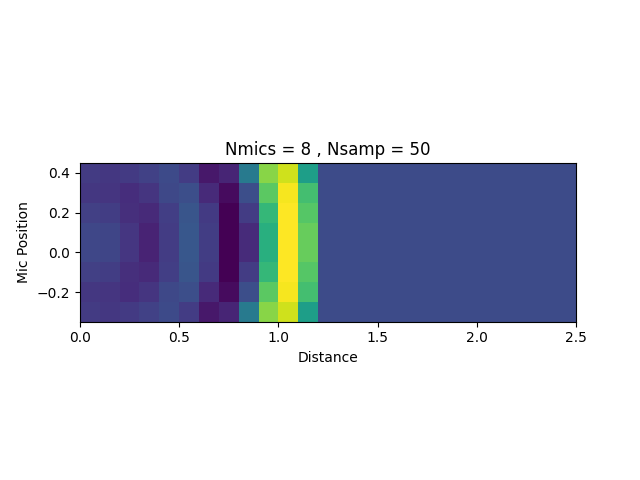

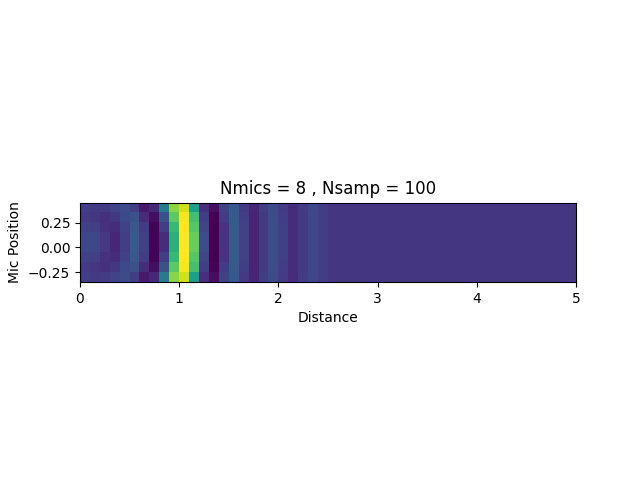

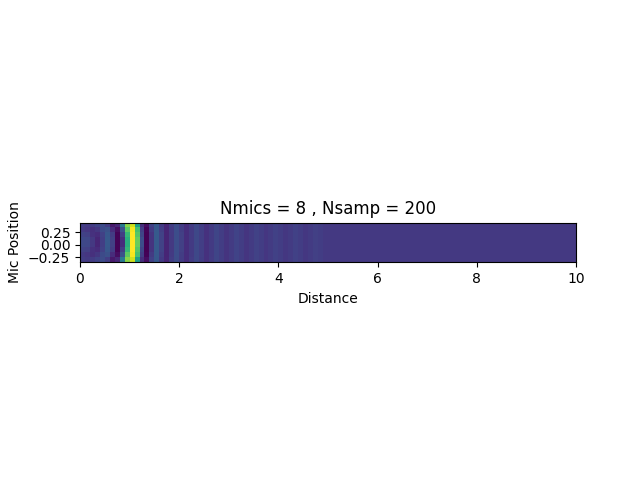

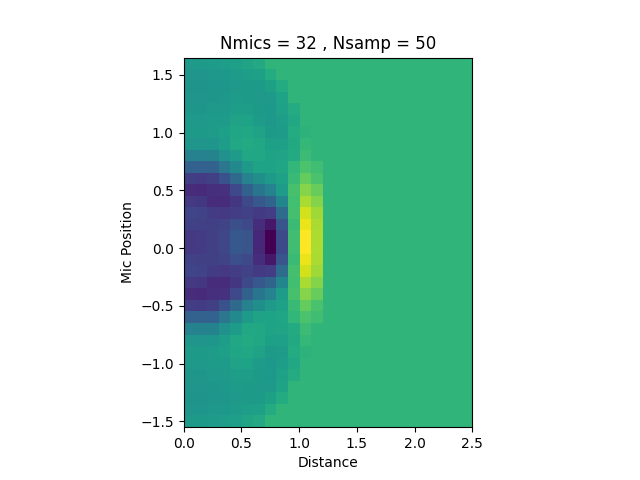

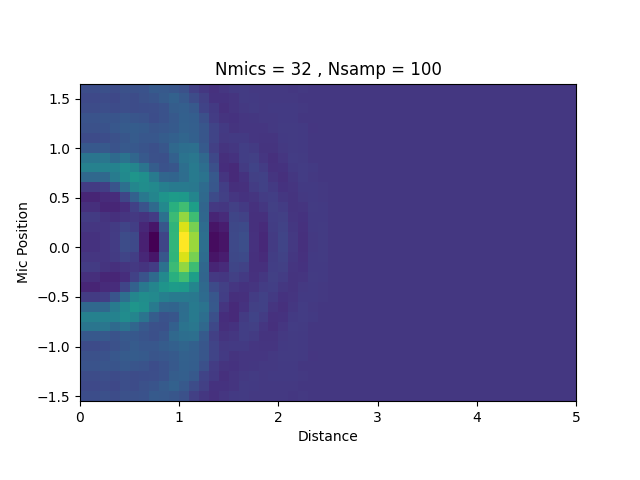

C:\Users\Dhruv Prasad\AppData\Local\Temp\ipykernel_4512\1980731908.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


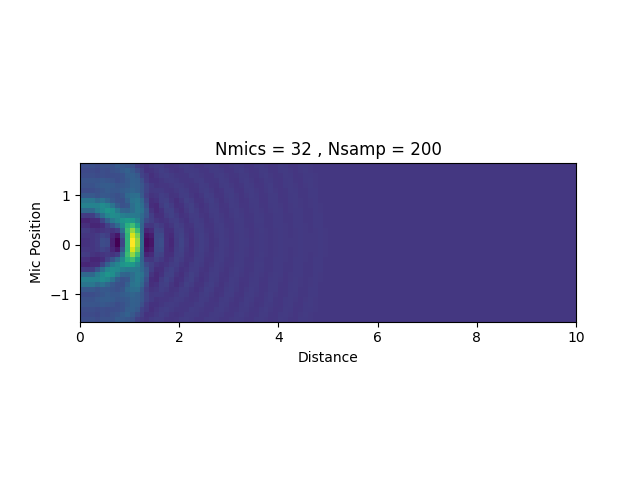

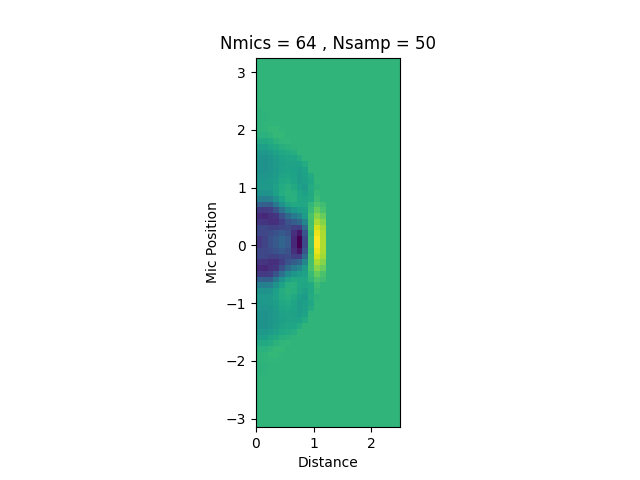

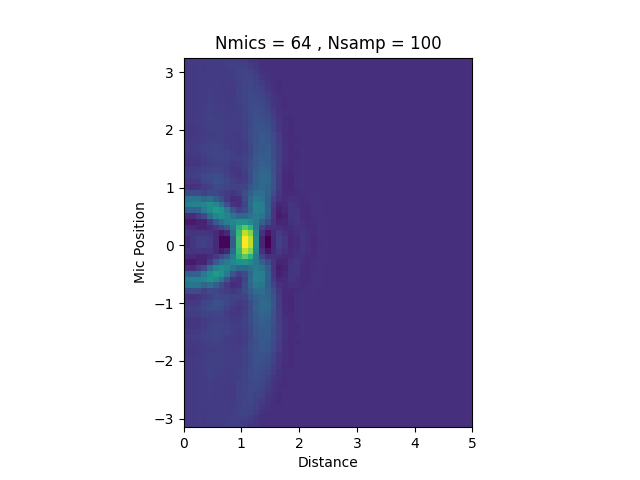

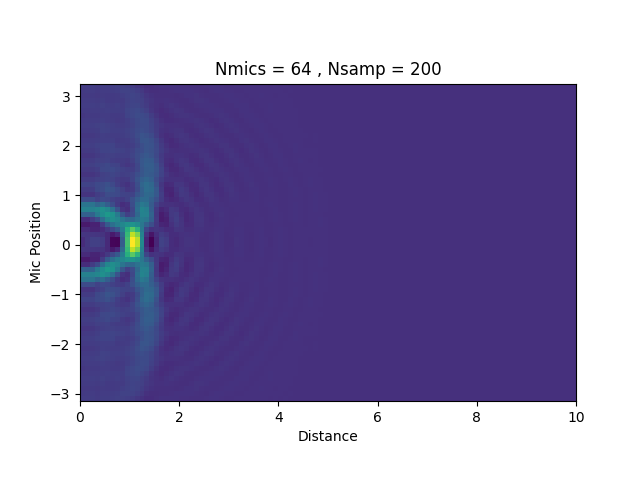

In [18]:
test_Nmics = [8, 32, 64]
test_Nsamp = [50, 100, 200]
src = (0, 0)
obstacle = (1,0)
pitch = 0.1
dist_per_samp = 0.1
c = 2.0
SincP = 5.0
for nm in test_Nmics:
    for ns in test_Nsamp:
        mics=get_mic_positions(pitch=pitch, Nmics=nm)
        sample, _ =generate_sample(Nsamp=ns, Nmics=nm, src=src, obstacle=obstacle, mics=mics, dist_per_samp=dist_per_samp)
        plot_heatmap(outputs_list=sample, Nsamp=ns, Nmics=nm, pitch=pitch, dist_per_samp=dist_per_samp)